<a href="https://colab.research.google.com/github/arnaldobjunior/ML/blob/main/closed_eyes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# O projeto

O projeto tem por objetivo identificar faces para discernir se os olhos estão abertos ou fechados. Para realiza-lo, é necesário aplicar técnicas de visão computacional e apredizado de máquina.








# Dataframes


In [ ]:
import dlib as dl
import cv2
import imutils 
import numpy as np
import glob
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

closed = []
opened = []

#lendo as imagens
for file in glob.glob('/content/sample_data/closed/*.jpg'):
  closed.append(cv2.imread(file))
for file in glob.glob('/content/sample_data/open/*.jpg'):
  opened.append(cv2.imread(file))

data = pd.DataFrame(columns=['filename','class'])

for file in closed:
  data = data.append({'filename':file,
                      'class':0},ignore_index=True)
for file in opened:
  data = data.append({'filename':file,
                      'class':1},ignore_index=True)
#embaralhando dataframe
data_shuffle=shuffle(data)

#separando em treino, teste e validação
X_train, X_test, y_train, y_test = train_test_split(data_shuffle.iloc[:,[0]],data_shuffle.iloc[:,[1]],test_size = 0.3, random_state=10)
X_test,X_valida,y_test,y_valida  = train_test_split(X_test,y_test,test_size = 0.5, random_state=10)


In [ ]:
#modelo para encontrar as landmarks 
det = dl.get_frontal_face_detector()
predic = dl.shape_predictor('/content/shape_predictor_68_face_landmarks.dat')

Funções


In [ ]:
from imutils import face_utils
from scipy.spatial import distance

#pega os pontos na imagem
def shape_function(img):
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  rects = det(gray, 1)
  for (i, rect) in enumerate(rects):
    shape = predic(gray, rect)
    shape = face_utils.shape_to_np(shape)
    return shape

#desenha os pontos na imagem
def draw(img,shape):
  for i in range(0,68):
    img = cv2.circle(img,(shape[i,0],shape[i,1]), 1, (0,255,0), thickness=-1)
  return img

#Calcula a distancia euclidiana entre dois pontos no olhos
def dist_eucli(shape):
  eye_left = shape[36:42]
  eye_right = shape[42:48]
  dist_left = distance.euclidean(eye_left[1],eye_left[5])
  dist_right = distance.euclidean(eye_right[1],eye_right[5])
  dist_med = (dist_left + dist_right)/2
  return dist_med

Funções coluna


In [ ]:
#cria a coluna shape
def column_shape(x):  
  shape_list = []
  a = np.zeros(shape=(68,2),dtype=int)
  for i in range(0,len(x)):
    array = x.iloc[i,0].copy()
    shape = shape_function(array)
    if shape is None:
      shape = a
    shape_list.append(shape)
  x.loc[:,"shape"] = shape_list

#cria a coluna desenho
def draw_in(x):
  canvas_list = []
  a = np.zeros(shape=((100,100,3)))
  for i in range(0,len(x)):
    array = x.iloc[i,0]
    shapes = x.iloc[i,1]
    if shapes is None:
      canvas_list.append(a)
    else:
      canvas_list.append(draw(array,shapes))

#cria a coluna distancia
def column_dist(x):  
  dist_list = []
  for i in range(0,len(x)):
    array = x.iloc[i,0]
    dist_list.append(dist_eucli(x.iloc[i,1]))
  x.loc[:,"distancia"] = dist_list

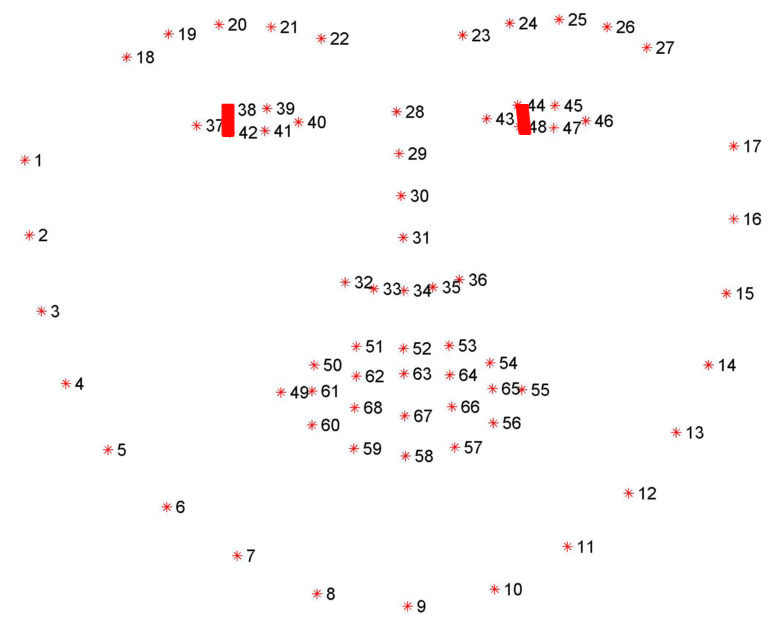

In [ ]:
#carregando funções
column_shape(X_train)
draw_in(X_train)
column_dist(X_train)

column_shape(X_test)
draw_in(X_test)
column_dist(X_test)

column_shape(X_valida)
draw_in(X_valida)
column_dist(X_valida)

In [ ]:
X_train.head()

,filename,shape,distancia
2134,"[[[144, 183, 192], [141, 180, 189], [144, 180,...","[[7, 35], [8, 47], [8, 58], [9, 69], [12, 80],...",3.500000
1166,"[[[0, 255, 0], [0, 255, 0], [32, 38, 43], [25,...","[[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0...",0.000000
956,"[[[212, 218, 217], [212, 220, 219], [215, 223,...","[[13, 43], [13, 52], [15, 62], [17, 72], [20, ...",1.207107
924,"[[[0, 255, 0], [0, 255, 0], [38, 44, 43], [38,...","[[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0...",0.000000
2261,"[[[41, 46, 49], [51, 56, 59], [50, 55, 58], [3...","[[6, 41], [7, 52], [8, 63], [10, 74], [13, 84]...",5.000000


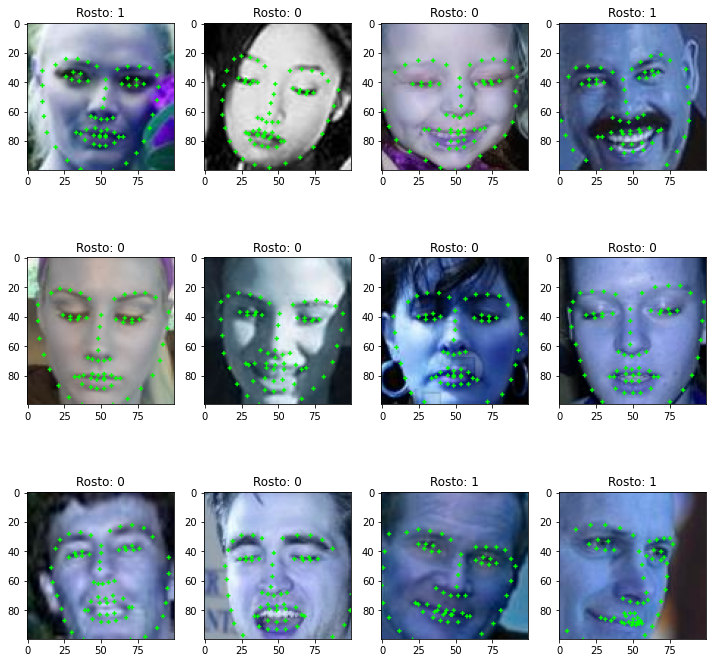

In [ ]:
import random 
import matplotlib.pyplot as plt

#Plotando o dataframe com seus respectivos resultados, 0 para olhos fechados e 1 para olhos abertos.
fig,ax=plt.subplots(3,4)
fig.set_size_inches(10,10)
for i in range(3):
    for j in range (4):
        r = random.randint(1,100)
        ax[i,j].imshow(X_train.iloc[r,0])
        ax[i,j].set_title('Rosto: '+ np.array( y_train,dtype=str )[r,0])
        
plt.tight_layout()




# Treinando o modelo

Regressão logística

In [ ]:
from sklearn.linear_model import LogisticRegression

log = LogisticRegression()
log.fit(np.array(X_train["distancia"]).reshape(-1, 1), np.array(y_train["class"],dtype=int).reshape(-1, 1))

In [ ]:
predictions = log.predict(np.array(X_valida["distancia"]).reshape(-1, 1))

# Métricas de avaliação

Matriz de confusão

In [ ]:
y_valida = np.array(y_valida,dtype=bool)
predictions = np.array(predictions.reshape(-1,1),dtype=bool)

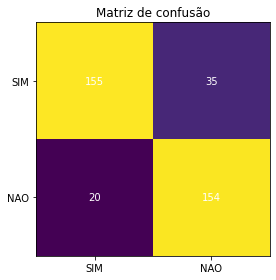

In [ ]:
#Encontrando os valroes da matriz de confusão
vn,fn,fp,vp = 0,0,0,0
for i in range(len(predictions)):
  if y_valida[i] == True:
    if y_valida[i] == predictions[i]:
      vp = vp + 1
    else:
      fn = fn + 1
  else:
    if y_valida[i] == predictions[i]:
      vn = vn + 1
    else:
      fp = fp + 1

#Plotando matriz de confusão
titles = ["SIM","NAO"]
array_matrix = np.array([[vp,fn],
                         [fp,vn]])

fig, ax = plt.subplots()
im = ax.imshow(array_matrix)
ax.set_xticks(np.arange(len(titles)))
ax.set_yticks(np.arange(len(titles)))
ax.set_xticklabels(titles)
ax.set_yticklabels(titles)

for i in range(len(titles)):
    for j in range(len(titles)):
        text = ax.text(j, i, array_matrix[i, j],
                       ha="center", va="center", color="w")

ax.set_title("Matriz de confusão")
fig.tight_layout()
plt.show()


Acurácia, precisão, sensibilidade e F1-Score

In [ ]:
acuracia = (vp+vn)/(vp+vn+fp+fn)
precisao = vp/(vp+fp)
sensibilidade = vp/(vp+fn)
f1 = (2*precisao*sensibilidade)/(precisao+sensibilidade)

In [ ]:
print(f"Acurácia: {acuracia*100:.2f}%")
print(f"Precisão: {precisao*100:.2f}%")
print(f"Sensbilidade:{ sensibilidade*100:.2f}%")
print(f"F1 - Score: {f1*100:.2f}%")

Acurácia: 84.89%
Precisão: 88.57%
Sensbilidade:81.58%
F1 - Score: 84.93%
